## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import zscore
import itertools
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [2]:
def ts_from_csv(csv_path, resampling = "h"):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['date_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    df.set_index('date_time', inplace=True)
    df.drop(columns=['date', 'time'], inplace=True)

    df = df.resample(resampling).sum().fillna(0)
    for col in df.columns:
        df[col] = np.where(zscore(df[col]) > 3, df[col].median(), df[col])

    return df

In [62]:
df = ts_from_csv("incoming.csv", "d")
target_column = "incoming_volume"
df[target_column]/=df[target_column].max()
data = df[target_column]

In [63]:
test_size = 0.2

train_size = int(len(data) * (1 - test_size))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

## Подбор параметров

In [5]:
def train_ARIMA(
    train_data,
    p_range,
    d_range,
    q_range
) -> pd.DataFrame:

    results = []
    for p, d, q in tqdm(list(itertools.product(p_range, d_range, q_range))):
        try:
            model = SARIMAX(
                train_data,
                order=(p, d, q),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=True)

            current_aic = model_fit.aic
            results.append({
                "order" : (p, d, q),
                "AIC" : current_aic
            }
            )

            # print(f'ARIMA({p},{d},{q}) - AIC:{current_aic}')
        except Exception as e:
            print(e)
            continue
    return pd.DataFrame(results)


In [6]:
def train_SARIMAX(
    train_data,
    p_range,
    d_range,
    q_range,
    P_range,
    D_range,
    Q_range,
    m,
    exoq
) -> pd.DataFrame:

    results = []
    for p, d, q, P, D, Q in tqdm(list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))):
        try:
            model = SARIMAX(
                train_data,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=exoq,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=True)

            current_aic = model_fit.aic
            results.append({
                "order" : (p, d, q),
                "seasonal_order" : (P, D, Q, m),
                "AIC" : current_aic
            }
            )
        except Exception as e:
            print(e)
            continue
    return pd.DataFrame(results)

def train_SARIMA(
    train_data,
    p_range,
    d_range,
    q_range,
    P_range,
    D_range,
    Q_range,
    m,
) -> pd.DataFrame:
    return train_SARIMAX(
        train_data,
        p_range,
        d_range,
        q_range,
        P_range,
        D_range,
        Q_range,
        m,
        None
    )


In [ ]:
res_arima = train_ARIMA(
    train_data,
    p_range=[1,2,12,24],
    d_range=[0],
    q_range=[1,2,12,24]
)
res_arima.sort_values(by="AIC")

In [ ]:
res_sarima = train_SARIMA(
    train_data,
    p_range=[1,2,12,],
    d_range=[0],
    q_range=[1,2,12,],
    P_range=[1,2,3],
    D_range=[0],
    Q_range=[1,2,3],
    m=24
)
res_sarima.sort_values(by="AIC")

In [43]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

def create_exog(
        df,
        one_hot = True
):
    data = {
        "day" : df.index.day,
        "quarter" : df.index.quarter,
        "day_of_week" : df.index.day_of_week,
        "month" : df.index.month,
    }
    # Временные компоненты (если в данных есть время)
    has_time = (df.index.hour > 0).any() or (df.index.minute > 0).any()
    if has_time:
        data["hour"] = df.index.hour
    exog = pd.DataFrame(
        data,
        index=df.index
    )
    if one_hot:
        exog = encoder.fit_transform(exog)
    return exog


In [64]:
exoq = create_exog(df)
train_exoq = exoq[:train_size]
test_exoq = exoq[train_size:]


In [ ]:
res_sarima = train_SARIMAX(
    train_data,
    p_range=[1,2,12,],
    d_range=[0],
    q_range=[1,2,12,],
    P_range=[1,2,3],
    D_range=[0],
    Q_range=[1,2,3],
    exoq=train_exoq
)
res_sarima.sort_values(by="AIC")

## Оценка качества

In [13]:
def eval_arma(
    model,
    test_data,
    test_exoq = None
):

    forecast = model.forecast(steps=len(test_data),exoq=test_exoq)
    # Расчет метрик качества
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    mae = mean_absolute_error(test_data, forecast)


    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    # Визуализация прогноза
    plt.figure(figsize=(12, 6))
    plt.plot(test_data, label='Y_true')

    # Построение прогноза на тестовом периоде
    forecast = forecast[:300]
    forecast_index = test_data.index[:300]
    plt.plot(forecast_index, forecast, color='red', label=f'Preditions')

    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
import joblib
dir = "models"
task = "inc_day"
train_data.to_csv(f"{dir}/{task}/train.csv")

In [18]:
len(train_data)

8896

MAE: 0.18226876157162428
RMSE: 0.2153307127069417


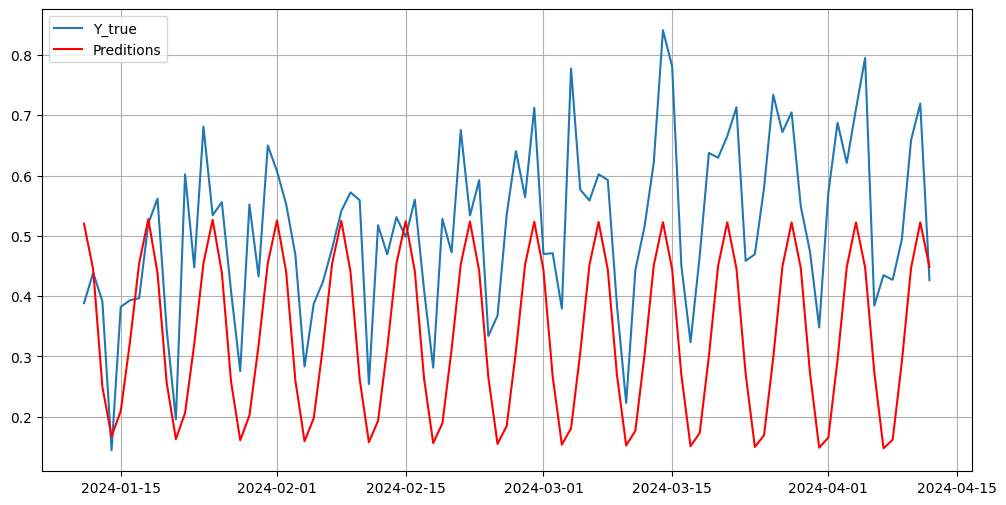

In [66]:
model = SARIMAX(
            train_data,
            order=(7, 0, 7),
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
model_fit = model.fit(disp=True)
eval_arma(
    model_fit,
    test_data
)
import pickle
params = model_fit.params
with open(f"{dir}/{task}/ARIMA.pkl", 'wb') as f:
    pickle.dump({
        'params': params,
        'order': (7, 0, 7),  # ваши параметры порядка
        'seasonal_order': (0, 0, 0, 0)  # сезонные параметры
    }, f)

MAE: 0.11274447372524043
RMSE: 0.1408182264111107


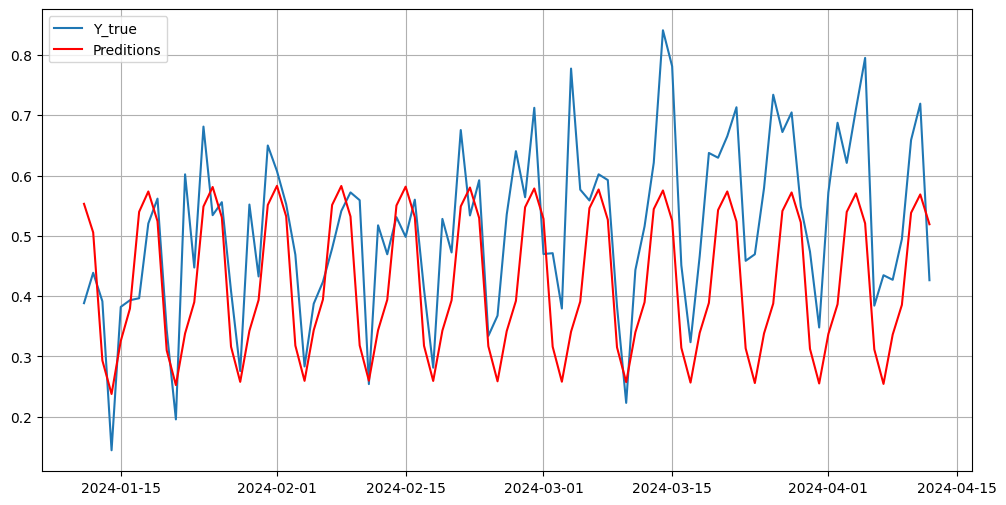

In [67]:
model = SARIMAX(
            train_data,
            order=(2, 0, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
model_fit = model.fit(disp=True)
eval_arma(
    model_fit,
    test_data
)
params = model_fit.params
with open(f"{dir}/{task}/SARIMA.pkl", 'wb') as f:
    pickle.dump({
        'params': params,
        'order': (2, 0, 1),  # ваши параметры порядка
        'seasonal_order': (1, 0, 1, 7)  # сезонные параметры
    }, f)


In [50]:
# При сохранении сохраните параметры отдельно
# import pickle
# params = model_fit.params
# with open(f"{dir}/{task}/SARIMA_params.pkl", 'wb') as f:
#     pickle.dump({
#         'params': params,
#         'order': (3, 0, 4),  # ваши параметры порядка
#         'seasonal_order': (1, 0, 1, 24)  # сезонные параметры
#     }, f)

# При загрузке создайте новую модель с теми же параметрами
with open(f"{dir}/{task}/SARIMA.pkl", 'rb') as f:
    saved_data = pickle.load(f)

# Создайте новую модель с новыми данными
new_model = SARIMAX(train_data, 
                    order=saved_data['order'],
                    seasonal_order=saved_data['seasonal_order'])
new_result = new_model.smooth(saved_data['params'])
forecast = new_result.forecast(steps=1)


MAE: 0.10393885262964932
RMSE: 0.15837313402186481


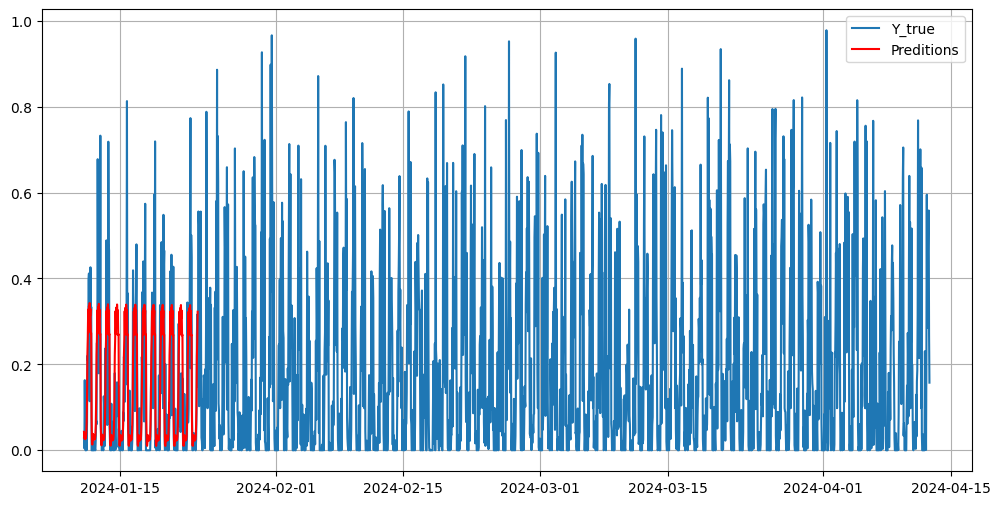

In [34]:
eval_arma(
    new_result,
    test_data
)

In [32]:
model_fit.save(f"{dir}/{task}/SARIMA_.pkl", )

MAE: 0.10393885727777037
RMSE: 0.1583731087989607


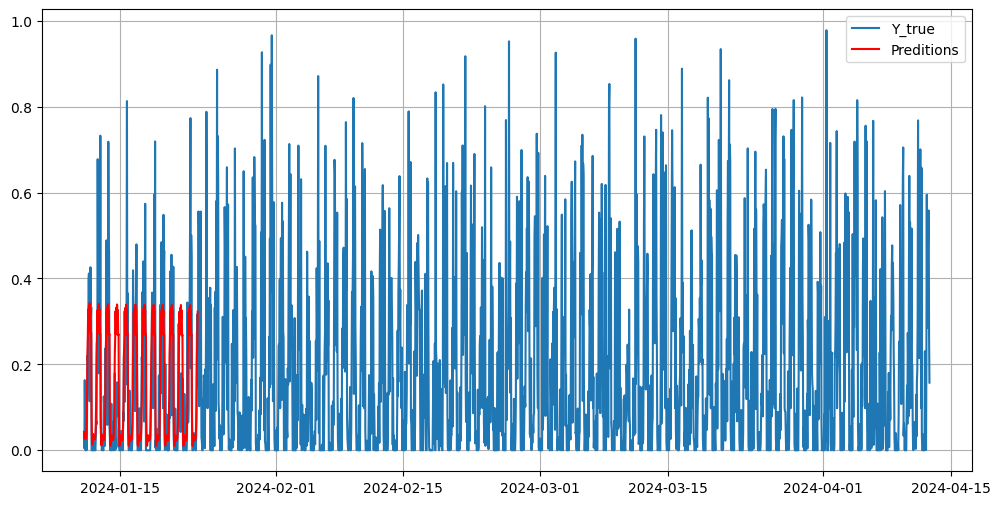

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

model_fit = SARIMAXResults.load(f"{dir}/{task}/SARIMA_.pkl")
model_fit
eval_arma(
    model_fit,
    test_data
)

MAE: 0.11224687354793741
RMSE: 0.14036234738501216


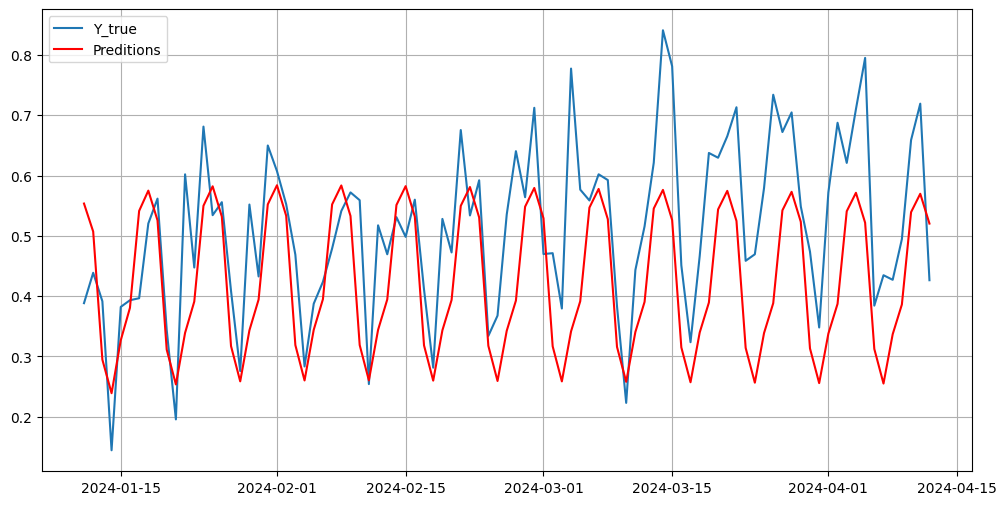

In [68]:
model = SARIMAX(
            train_data,
            exoq=train_exoq,
            order=(1, 0, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
model_fit = model.fit(disp=True)
eval_arma(
    model_fit,
    test_data,
    test_exoq
)

import pickle
params = model_fit.params
with open(f"{dir}/{task}/SARIMAX.pkl", 'wb') as f:
    pickle.dump({
        'params': params,
        'order': (5, 0, 5),  # ваши параметры порядка
        'seasonal_order': (1, 0, 1, 7)  # сезонные параметры
    }, f)
